**Atmospheric Correction Using Dark Channel Prior Method**

Done By:
1. Gurudatta Tej Marupudi
2. Mohammad Sohail Sayed

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the libraries

In [9]:
!pip install elevation
!pip install pysheds
!pip install fiona
!pip install rasterio
!pip install pyproj
!pip install geopandas
!pip install rioxarray
!pip install earthpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 417, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 320, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 194, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 241, in _build_one_inside_en

In [11]:
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import rasterio
import cv2

Combine bands and form rgb image

In [12]:
def display_rgb(band_paths):
  bands = [rasterio.open(band_path).read(1) for band_path in band_paths]
  # Stack all bands along the third axis to create a 3D array
  rgb_image = np.stack((bands[2], bands[1], bands[0]), axis=-1)
  plt.imshow(rgb_image)
  plt.title('Landsat True-Color Composite')
  return rgb_image

Display the meta data

In [73]:
from tabulate import tabulate

landsat_mlt_dict = {}
landsat_metadata_path = '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_MTL.txt'

with open(landsat_metadata_path, 'r') as _:
    for line in _:
        line = line.strip()
        if line != 'END':
            key, value = line.split('=')
            landsat_mlt_dict[key] = value

mlt_table = tabulate(landsat_mlt_dict.items(), headers=['Parameter', 'Value'], tablefmt='grid')
print(mlt_table)

+---------------------------------------------+----------------------------------------------------------+
| Parameter                                   | Value                                                    |
+=============================================+==========================================================+
| GROUP                                       | PRODUCT_PARAMETERS                                       |
+---------------------------------------------+----------------------------------------------------------+
| ORIGIN                                      | "Image courtesy of the U.S. Geological Survey"           |
+---------------------------------------------+----------------------------------------------------------+
| DIGITAL_OBJECT_IDENTIFIER                   | "https://doi.org/10.5066/P9TU80IG"                       |
+---------------------------------------------+----------------------------------------------------------+
| LANDSAT_PRODUCT_ID                 

Check for the Cloud Cover

In [36]:
metadata= '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_MTL.txt'

#check for the cloud cover
def check_cloud_cover(metadata_path):
    with open(metadata_path, 'r') as file:
        for line in file:
            line = line.strip()
            if 'CLOUD_COVER' in line:
                key, value = map(str.strip, line.split('='))
                cloud_cover = float(value)
                return cloud_cover
    return None

def assess_atmospheric_errors(metadata_path,cloud_cover_threshold):
    # Check cloud cover percentage
    cloud_cover = check_cloud_cover(metadata_path)

    if cloud_cover is not None:
        print(f"Cloud Cover Percentage: {cloud_cover}%")

        # Assess atmospheric errors based on the cloud cover threshold
        if cloud_cover > cloud_cover_threshold:
            print("High cloud cover may indicate atmospheric interference.")
        else:
            print("Low cloud cover suggests lower likelihood of atmospheric interference.")
    else:
        print("Cloud cover information not found in metadata.")
# Set your desired cloud cover threshold (percentage)
cloud_cover_threshold = 10.0

# Call the function to assess atmospheric errors
assess_atmospheric_errors(metadata,cloud_cover_threshold)

Cloud Cover Percentage: 60.0%
High cloud cover may indicate atmospheric interference.


Read the bands and display the corresponding rgb image

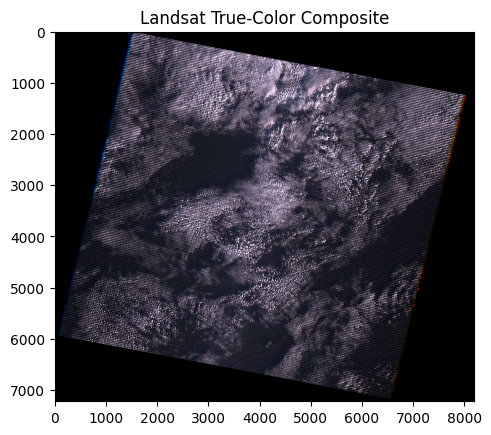

In [15]:
# for Landsat7 Images
band_paths2= ['/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B1.TIF',
              '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B2.TIF',
              '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B3.TIF',
              '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B4.TIF',
              '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B5.TIF',
              '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_B7.TIF']

qa_band_path2= '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/LE07_L1TP_018034_20231028_20231123_02_T1_QA_PIXEL.TIF'

rgb_image=display_rgb(band_paths2)

In [66]:
import rasterio
import numpy as np

# Read each band separately
bands = []
for band_path in band_paths2:
    with rasterio.open(band_path) as src:
        bands.append(src.read(1))

# Stack the bands to create an RGB-like image
rgb_image = np.stack([bands[3], bands[2], bands[1]], axis=-1)  # Assuming bands 4, 3, and 2 for RGB

# Get metadata from one of the bands
with rasterio.open(band_paths2[0]) as src:
    metadata = src.meta.copy()

# Update metadata for the RGB image
metadata.update({
    'count': 3,  # Number of bands in the RGB image
    'dtype': rgb_image.dtype
})

# Save the RGB image as a TIFF file
output_path = '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/output_rgb_image.tif'
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(rgb_image.transpose(2, 0, 1))


## Dark Channel Prior Method

In [49]:
def dark_channel_prior(img, window_size=15):
    # Calculate the dark channel prior for each pixel
    dark_channel = cv2.erode(np.min(img, axis=2), np.ones((window_size, window_size)))
    return dark_channel

def est_atmospheric_light(dark_channel, img):
    # Find the pixel with the maximum dark channel value
    atmospheric_light_pixel = np.unravel_index(np.argmax(dark_channel), dark_channel.shape)
    atmospheric_light = np.max(img[atmospheric_light_pixel[0], atmospheric_light_pixel[1], :])
    return atmospheric_light

def atmosp_correction(img, atmospheric_light, omega=0.95, window_size=15):
    # Estimate the transmission map
    dark_channel = dark_channel_prior(img, window_size)
    transmission_map = 1 - omega * dark_channel / atmospheric_light

    # Clip transmission map to avoid artifacts
    transmission_map = np.clip(transmission_map, 0.1, 1.0)

    # Perform atmospheric correction
    corrected_img = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        corrected_img[:, :, i] = (img[:, :, i].astype(np.float32) - atmospheric_light) / transmission_map + atmospheric_light

    # Clip values to the valid range [0, 255]
    corrected_img = np.clip(corrected_img, 0, 255).astype(np.uint8)

    return corrected_img


# Load the input image
input_img = cv2.imread('/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/output_rgb_image.tif')

# Atmospheric correction parameters
window_size = 15
omega = 0.95

# Perform atmospheric correction
dark_channel = dark_channel_prior(input_img, window_size)
atmospheric_light = est_atmospheric_light(dark_channel, input_img)
corrected_img = atmosp_correction(input_img, atmospheric_light, omega, window_size)

In [55]:
# Save corrected image to output path
corrected_output_path = '/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/darkchannel_corrected_image.tif'  # Replace it with your desired output path
cv2.imwrite(corrected_output_path, corrected_img)
print(f"Corrected image saved to {corrected_output_path}")

Corrected image saved to /content/drive/MyDrive/major_Project/Datasets/Lansat7_2/darkchannel_corrected_image.tif


### plot the pixel value vs frequency histograms

In [71]:
def plot_pixel_value_vs_frequency(image):
    # Convert the image to grayscale if it's a color image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate the histogram
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Create an array of pixel values
    pixel_values = np.arange(256)

    # Plot pixel value vs. frequency using bars
    plt.bar(pixel_values, histogram.flatten(), color='blue', alpha=0.7, width=1.5)
    plt.title('Pixel Value vs. Frequency')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

Before Correction


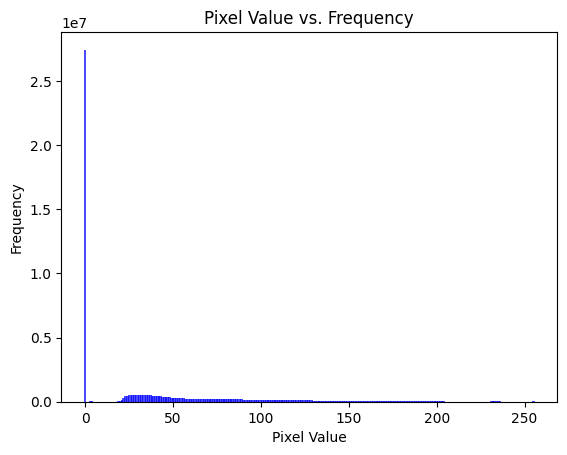

After Correction


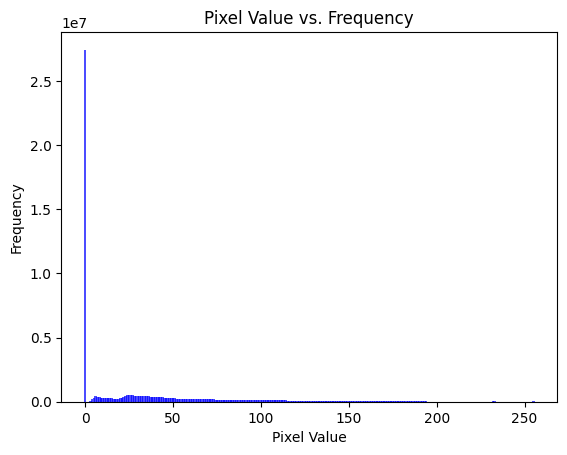

In [72]:
#histogram before correction
print("Before Correction")
image = cv2.imread('/content/drive/MyDrive/major_Project/Datasets/Lansat7_2/output_rgb_image.tif')
# Plot pixel value vs. frequency
plot_pixel_value_vs_frequency(image)

#histogram after correction
 # Replace with your image path
image = cv2.imread(corrected_output_path)
print("After Correction")
# Plot pixel value vs. frequency
plot_pixel_value_vs_frequency(image)
